In [1]:
# import packages
import datetime
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.regularizers import l2, l1
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


2025-01-08 15:45:43.148717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736347543.168489   88414 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736347543.173846   88414 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 15:45:43.195179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1

In [2]:
df = pd.read_csv('faults.csv')
df.columns = map(str.lower, df.columns)
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']
enc_dict = {'pastry' : 0,
            'z_scratch' : 1,
            'k_scatch' : 2,
            'stains' : 3,
            'dirtiness' : 4,
            'bumps' : 5,
            'other_faults' : 6}
df.drop(391, inplace = True)
df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
sm = SMOTE()
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)
sc = StandardScaler()
nonbin_norm = sc.fit_transform(df_nonbin)
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum', 'typeofsteel_a400'], axis = 1, inplace = True)
df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)
df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)
df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)
df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)
df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

# 2

I0000 00:00:1734594805.347053    4420 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3490 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/200


I0000 00:00:1734594809.197375    5919 service.cc:148] XLA service 0x7fec4000d840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734594809.197404    5919 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-12-19 08:53:29.279591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734594809.640958    5919 cuda_dnn.cc:529] Loaded cuDNN version 90600


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.2055

I0000 00:00:1734594811.863416    5919 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.2055 - val_loss: 0.7807
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.1662 - val_loss: 0.7572
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1.1301 - val_loss: 0.7306
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.0923 - val_loss: 0.7006
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 1.0527 - val_loss: 0.6676
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.0116 - val_loss: 0.6332
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.9708 - val_loss: 0.6003
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.9330 - val_loss: 0.5729
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.9019 - val_loss: 0.5551
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.8802 - val_loss: 0.5457
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.8643 - val_loss: 0.5372
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.8454 - val_loss:

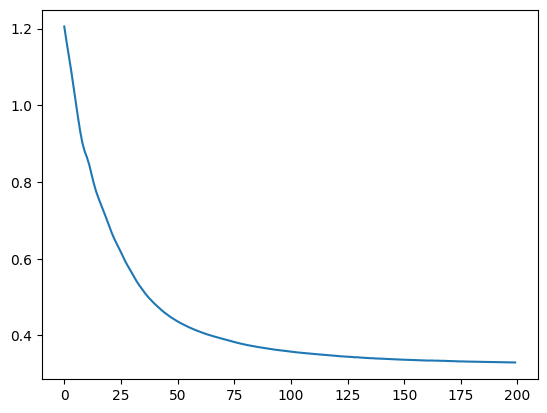

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fitting 5 folds for each of 25 candidates, totalling 125 fits


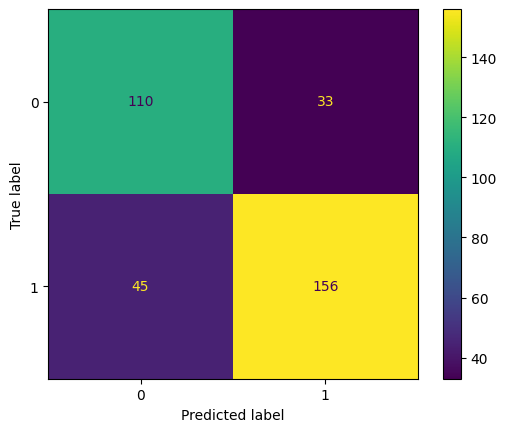

Accuracy score for SVM: 0.77%


In [3]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(256, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

## decoding part
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

df_norm = df_norm[df_norm['anomaly'] >= 5]

#y = tf.keras.utils.to_categorical(y)

x_5, x_6 = X[y == 5], X[y == 6]

history = autoencoder.fit(x_5[0:200], x_5[0:200], 
                batch_size = 256, epochs = 200, 
                shuffle = True, validation_split = 0.20)

plt.plot(history.history['loss'])
plt.show()

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])

cinque_hid_rep = hidden_representation.predict(x_5[:473])
sei_hid_rep = hidden_representation.predict(x_6)

rep_x = np.append(cinque_hid_rep, sei_hid_rep, axis = 0)
y_n = np.zeros(cinque_hid_rep.shape[0])
y_n[y_n == 0] = 5
y_f = np.ones(sei_hid_rep.shape[0])
y_f[y_f == 1] = 6
rep_y = np.append(y_n, y_f)

rep_y = pd.DataFrame(rep_y)
rep_x = pd.DataFrame(rep_x)

X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size = 0.3, random_state = 2)

parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

svc = SVC()

clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

matplotlib.use('inline')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for SVM: {svm_accuracy}%')

# 3

In [3]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [4]:
# Input layer
input_layer = Input(shape=(X.shape[1],))

# Encoder: trasformazione verso lo spazio latente
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)


# Decoder: ricostruzione dei dati
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

# Classifier: predizione della classe
output_classification = Dense(7, activation = 'softmax', name = "classification")(encoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
classification = Model(inputs = input_layer, outputs = output_classification)

# Compile the model with a combined loss
autoencoder.compile(
    optimizer='adam',
    loss={
        "reconstruction": "mse",
        "classification": 'sparse_categorical_crossentropy'
    },
    loss_weights={"reconstruction": 0.5, "classification": 0.5},
    metrics = ['mse', 'accuracy']
)

# Train the autoencoder
history = autoencoder.fit(
    X_train, [X_train, y_train],  # Input: X, Outputs: [reconstruction, classification]
    batch_size=256,
    epochs=100,
    shuffle=True,
    validation_split = 0.2
)

I0000 00:00:1736347575.337101   88414 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3490 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


I0000 00:00:1736347579.296893   91323 service.cc:148] XLA service 0x7f3070013a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736347579.296930   91323 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-08 15:46:19.377352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736347579.851914   91323 cuda_dnn.cc:529] Loaded cuDNN version 90600


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - classification_accuracy: 0.2999 - classification_loss: 1.8547 - loss: 1.3928 - reconstruction_loss: 0.9309 - reconstruction_mse: 0.9309 

I0000 00:00:1736347582.975207   91323 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 517ms/step - classification_accuracy: 0.3223 - classification_loss: 1.8330 - loss: 1.3779 - reconstruction_loss: 0.9214 - reconstruction_mse: 0.9218 - val_classification_accuracy: 0.5889 - val_classification_loss: 1.3421 - val_loss: 1.0578 - val_reconstruction_loss: 0.7739 - val_reconstruction_mse: 0.7727
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_accuracy: 0.6733 - classification_loss: 1.0876 - loss: 0.9335 - reconstruction_loss: 0.7789 - reconstruction_mse: 0.7786 - val_classification_accuracy: 0.7891 - val_classification_loss: 0.6257 - val_loss: 0.6753 - val_reconstruction_loss: 0.7247 - val_reconstruction_mse: 0.7235
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - classification_accuracy: 0.7610 - classification_loss: 0.6253 - loss: 0.6687 - reconstruction_loss: 0.7116 - reconstruction_mse: 0.7118 - val_classification_accuracy: 0.8276 - val_classification_loss: 0.4782 - val_loss: 0.5794 - val_reconstruction_loss: 0.6807

In [5]:
# Define encoder model to extract latent features
encoder = Model(inputs = autoencoder.input, outputs = encoded)

# Generate latent representations
latent_features = encoder.predict(X_train)
latent_features_test = encoder.predict(X_test)
latent_features = sc.fit_transform(latent_features)
latent_features_test = sc.fit_transform(latent_features_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy of NN: 0.9%

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       139
           1       0.96      0.95      0.95       129
           2       0.99      1.00      1.00       126
           3       0.99      0.99      0.99       124
           4       0.95      1.00      0.98       139
           5       0.79      0.76      0.78       142
           6       0.72      0.65      0.69       144

    accuracy                           0.90       943
   macro avg       0.90      0.90      0.90       943
weighted avg       0.89      0.90      0.89       943



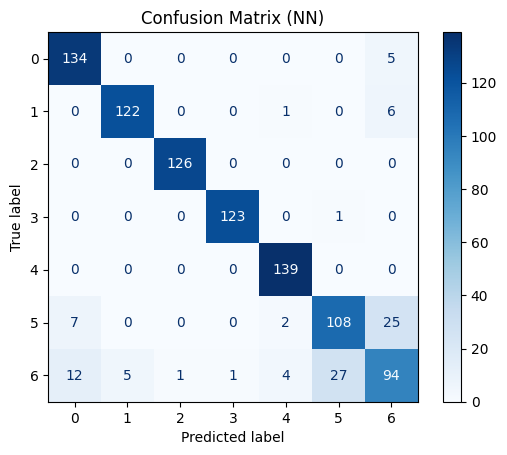

In [6]:
y_pred = classification.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
classifier_accuracy = round(accuracy_score(y_test, y_pred), 2)

print(f"Accuracy of NN: {classifier_accuracy}%")

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (NN)")
plt.show()

Accuracy of SVM: 0.91%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       139
           1       0.96      0.97      0.97       129
           2       0.98      1.00      0.99       126
           3       0.99      0.99      0.99       124
           4       0.95      1.00      0.98       139
           5       0.83      0.82      0.83       142
           6       0.78      0.69      0.73       144

    accuracy                           0.91       943
   macro avg       0.91      0.92      0.92       943
weighted avg       0.91      0.91      0.91       943



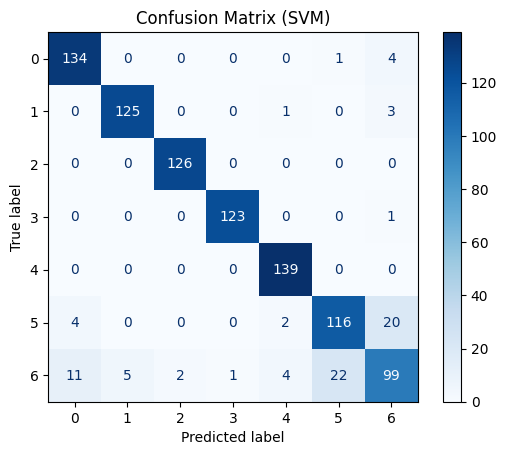

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train SVM
svc = SVC(kernel='rbf', C = 1, gamma = 0.01)
svc.fit(latent_features, y_train)

# Predict on test set
y_pred = svc.predict(latent_features_test)

# Evaluate SVM
svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy of SVM: {svm_accuracy}%")

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svc.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (SVM)")
plt.show()

focal loss